In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model,model_from_json
from tensorflow import keras

physical_devices=tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
SEED = 7
tf.keras.utils.set_random_seed(SEED) #Establece la semilla de Python, Numpy y TensorFlow. Para que los números aleatorios sean los mismos cada vez que se corre
tf.config.experimental.enable_op_determinism() #Para que con los mismos inputs, se tengan los mismos outputs cada vez que se corre

initial_learning_rate=1e-6
batch_size = 4
image_size = (224,224)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "../datasets/dataset_5/test/",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

accuracy=[]
tp=[]
tn=[]
fp=[]
fn=[]
recall=[]
precision=[]

for i in range(5):
    json_file = open('training_files/model_{}.json'.format(i), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights("training_files/model_{}.h5".format(i))
    print("Loaded model from disk")
    model=loaded_model

    model.compile(
        optimizer=keras.optimizers.Adam(initial_learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy","TruePositives","TrueNegatives","FalsePositives", "FalseNegatives","Recall","Precision"]
    )
    
    result=model.evaluate(x=test_ds,verbose=0,return_dict=True)
    accuracy.append(round(result["accuracy"]*100,2))
    tp.append(result["true_positives"])
    tn.append(result["true_negatives"])
    fp.append(result["false_positives"])
    fn.append(result["false_negatives"])
    recall.append(round(result["recall"]*100,2))
    precision.append(round(result["precision"]*100,2))

#df3=pd.DataFrame({"Accuracy":accuracy,"True Positives":tp,"True Negatives":tn,"False Positives":fp,"False Negatives":fn, "Recall":recall,"Precision":precision})
df3 = pd.DataFrame({"Values":accuracy+tp+tn+fp+fn+recall+precision,"Metric":["Accuracy"]*5+["TP"]*5+["TN"]*5+["FP"]*5+["FN"]*5+["Recall"]*5+["Precision"]*5})
with open("k_fold_comparison.csv", mode='w') as f:
        df3.to_csv(f)
#df3["k-fold"]=[1,2,3,4,5]
print(df3)

2023-12-10 20:16:38.119008: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 20:16:38.119048: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 20:16:38.119084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 20:16:38.127946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 20:16:39.304034: W tensorflow/compiler/

Found 430 files belonging to 2 classes.


2023-12-10 20:16:41.130985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12254 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6
2023-12-10 20:16:41.400107: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Loaded model from disk


2023-12-10 20:16:44.955811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8801
2023-12-10 20:16:45.701092: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
    Values     Metric
0    89.30   Accuracy
1    93.26   Accuracy
2    90.00   Accuracy
3    92.56   Accuracy
4    89.77   Accuracy
5   195.00         TP
6   201.00         TP
7   202.00         TP
8   203.00         TP
9   193.00         TP
10  189.00         TN
11  200.00         TN
12  185.00         TN
13  195.00         TN
14  193.00         TN
15   26.00         FP
16   15.00         FP
17   30.00         FP
18   20.00         FP
19   22.00         FP
20   20.00         FN
21   14.00         FN
22   13.00         FN
23   12.00         FN
24   22.00         FN
25   90.70     Recall
26   93.49     Recall
27   93.95     Recall
28   94.42     Recall
29   89.77     Recall
30   88.24  Precision
31   93.06  Precision
32   87.07  Precision
33   91.03  Precision
34   89.77  Precision


In [2]:
list_f1 = []
list_fnr = []
list_fpr = []
pos_rec = 25
pos_pre = 30
pos_tp = 5
pos_tn = 10
pos_fp = 15
pos_fn = 20

for i in range(5):
    recall = df3["Values"][pos_rec+i]
    precision = df3["Values"][pos_pre+i]
    tp = df3["Values"][pos_tp+i]
    tn = df3["Values"][pos_tn+i]
    fp = df3["Values"][pos_fp+i]
    fn = df3["Values"][pos_fn+i]

    f1=2*((recall*precision)/(recall+precision))
    list_f1.append(round(f1,2))

    fnr = fn/(tp+fn)
    list_fnr.append(round(fnr*100,2))
    
    fpr = fp/(fp+tn)
    list_fpr.append(round(fpr*100,2))

df4 = pd.DataFrame({"Values" : list_f1+list_fnr+list_fpr, "Metric" : ["F1 Score"]*5+["FNR"]*5+["FPR"]*5})

df5 = pd.concat([df3, df4], axis=0, ignore_index=True)
print(df5)

    Values     Metric
0    89.30   Accuracy
1    93.26   Accuracy
2    90.00   Accuracy
3    92.56   Accuracy
4    89.77   Accuracy
5   195.00         TP
6   201.00         TP
7   202.00         TP
8   203.00         TP
9   193.00         TP
10  189.00         TN
11  200.00         TN
12  185.00         TN
13  195.00         TN
14  193.00         TN
15   26.00         FP
16   15.00         FP
17   30.00         FP
18   20.00         FP
19   22.00         FP
20   20.00         FN
21   14.00         FN
22   13.00         FN
23   12.00         FN
24   22.00         FN
25   90.70     Recall
26   93.49     Recall
27   93.95     Recall
28   94.42     Recall
29   89.77     Recall
30   88.24  Precision
31   93.06  Precision
32   87.07  Precision
33   91.03  Precision
34   89.77  Precision
35   89.45   F1 Score
36   93.27   F1 Score
37   90.38   F1 Score
38   92.69   F1 Score
39   89.77   F1 Score
40    9.30        FNR
41    6.51        FNR
42    6.05        FNR
43    5.58        FNR
44   10.23

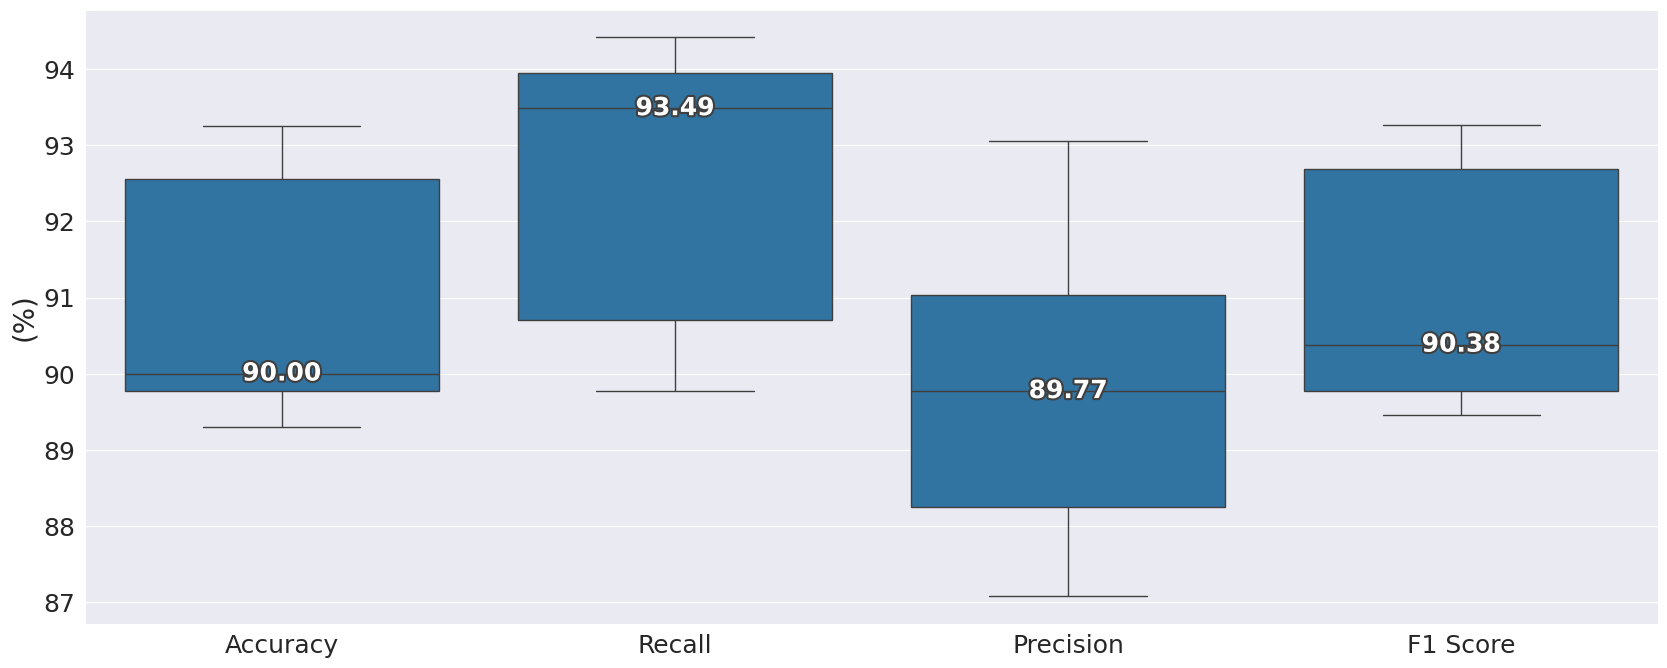

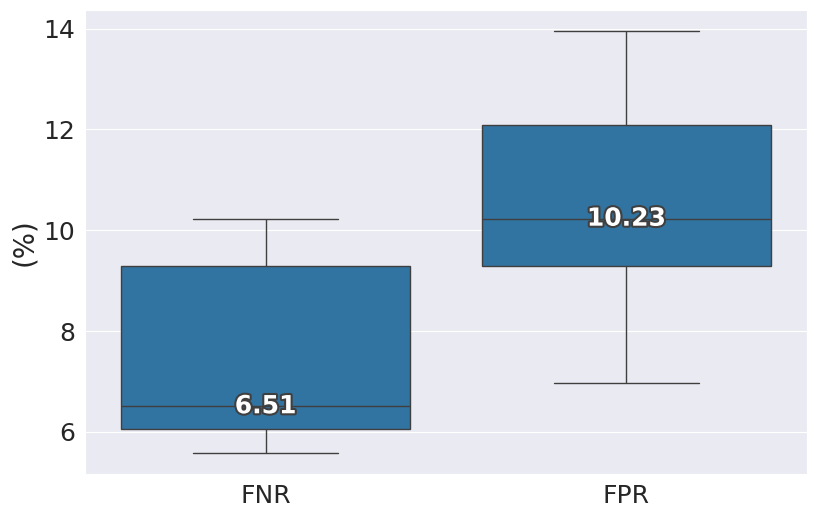

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
sns.set_style("darkgrid")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def add_median_labels(ax):
    lines = ax.get_lines()
    # determine number of lines per box (this varies with/without fliers)
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    # iterate over median lines
    for median in lines[4:len(lines):lines_per_box]:
        # display median value at center of median line
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1]-median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:.2f}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])
        
df6 = df5[df5['Metric'].isin(['Accuracy', 'Recall','Precision','F1 Score'])]
df7 = df5[df5['Metric'].isin(['FNR','FPR'])]

fig= plt.figure(figsize=(17,8))

box_plot=sns.boxplot(data=df6, x="Metric", y="Values")
add_median_labels(box_plot.axes)
plt.tight_layout(rect=[0, 0.03, 1.001, 0.95])
plt.xlabel(None)
plt.ylabel("(%)")
plt.show()

fig= plt.figure(figsize=(8.5,6))   

box_plot=sns.boxplot(data=df7, x="Metric", y="Values")
add_median_labels(box_plot.axes)
plt.xlabel(None)
plt.ylabel("(%)")
plt.tight_layout(rect=[0, 0.03, 1.001, 0.95])
plt.show()